# VGG16 & Transfere Learning

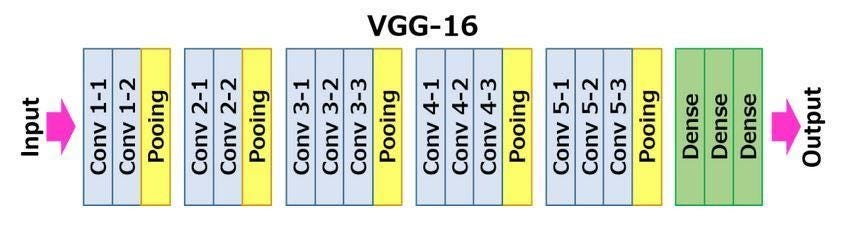

In [156]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam

### Download VGG16 without the Fully connected layer

In [157]:
vgg = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

### Make Fine Tuning for some layers to be learnable

In [158]:
# Freeze All Layers
for layer in vgg.layers:
    layer.trainable = False

### Build The Model

In [159]:
from tensorflow.keras.layers import GlobalAveragePooling2D

model = Sequential([
    vgg,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(6, activation='softmax')
])

In [160]:
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

### Data Augmentation & Preprocessing

In [161]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1
)

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

### Load the data from `seg_train` , `seg_test`

In [162]:
train_generator = train_datagen.flow_from_directory(
    'seg_train/seg_train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    subset='training'
)

val_generator = val_datagen.flow_from_directory(
    'seg_train/seg_train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    'seg_test/seg_test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    shuffle=False
)

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


### Make Early Stopping

In [163]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

### Training

In [164]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[early_stop]
)

Epoch 1/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 168s 470ms/step - accuracy: 0.2532 - loss: 3.8182 - val_accuracy: 0.4272 - val_loss: 2.1364
Epoch 2/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 163s 462ms/step - accuracy: 0.4140 - loss: 2.3127 - val_accuracy: 0.5895 - val_loss: 1.3420
Epoch 3/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 162s 462ms/step - accuracy: 0.5145 - loss: 1.7427 - val_accuracy: 0.6822 - val_loss: 1.0018
Epoch 4/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 160s 457ms/step - accuracy: 0.5928 - loss: 1.3891 - val_accuracy: 0.7354 - val_loss: 0.8230
Epoch 5/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 161s 459ms/step - accuracy: 0.6592 - loss: 1.1665 - val_accuracy: 0.7678 - val_loss: 0.7249
Epoch 6/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 162s 460ms/step - accuracy: 0.6771 - loss: 1.0436 - val_accuracy: 0.7885 - val_loss: 0.6663
Epoch 7/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 161s 459ms/step - accuracy: 0.7152 - loss: 0.9269 - val_accuracy: 0.8028 - val_loss: 0.6179
Epoch 8/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 161s 459ms/step - accuracy: 0.7479 -

### Evaluate on Validation data

In [165]:
val_loss, val_acc = model.evaluate(val_generator)
print("Validation Accuracy:", val_acc)

88/88 ━━━━━━━━━━━━━━━━━━━━ 16s 181ms/step - accuracy: 0.8196 - loss: 0.5188
Validation Accuracy: 0.8223965764045715


### Evaluate on Test data

In [166]:
test_loss, test_acc = model.evaluate(test_generator)
print("Test Accuracy:", test_acc)
print("Test Loss:", test_loss)

94/94 ━━━━━━━━━━━━━━━━━━━━ 17s 185ms/step - accuracy: 0.8452 - loss: 0.4877
Test Accuracy: 0.8176666498184204
Test Loss: 0.5751457810401917


### Plot Some Photos from test data with their pridiction

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 820ms/step


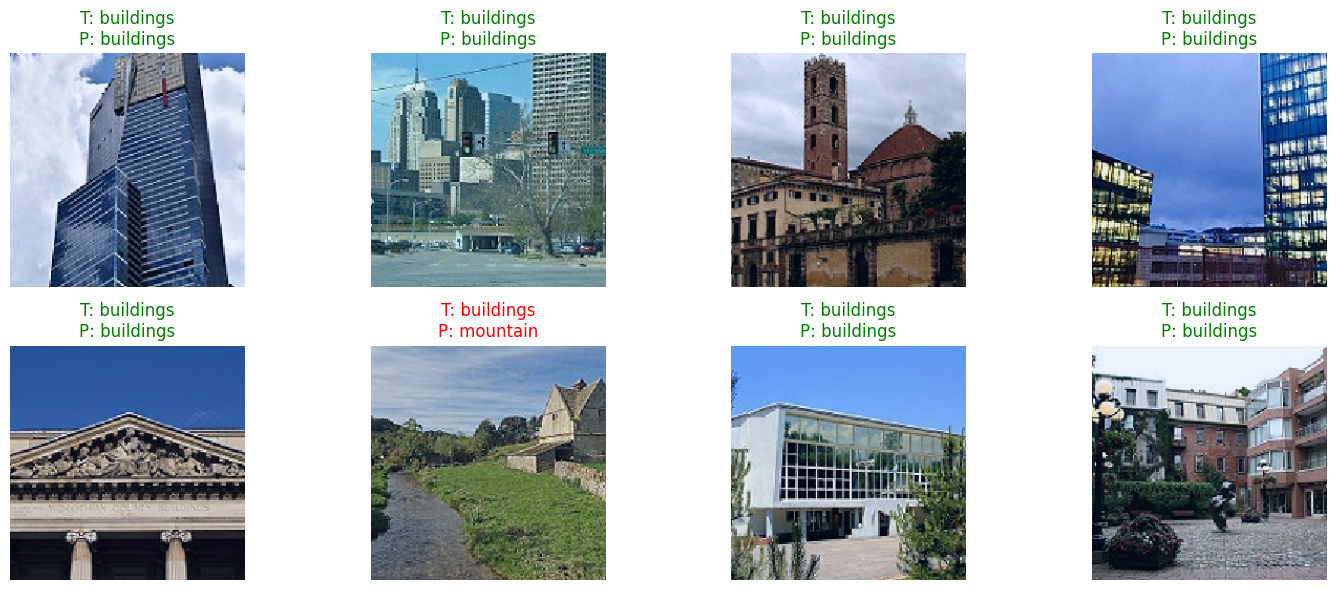

In [167]:
images, labels = next(test_generator)
preds = model.predict(images)
pred_labels = preds.argmax(axis=1)

import matplotlib.pyplot as plt

class_names = list(test_generator.class_indices.keys())

num_images = min(len(images), 8)

plt.figure(figsize=(15,6))

for i in range(num_images):
    plt.subplot(2, 4, i+1)

    img = images[i].copy()
    img = img[..., ::-1]
    img = (img - img.min()) / (img.max() - img.min())

    plt.imshow(img)
    plt.axis('off')

    true_label = class_names[int(labels[i])]
    pred_label = class_names[int(pred_labels[i])]

    color = "green" if labels[i] == pred_labels[i] else "red"

    plt.title(f"T: {true_label}\nP: {pred_label}", color=color)

plt.tight_layout()
plt.show()